<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/DCGAN_intro_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# for tf 2.0
!pip install -U tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /home/aaron-lab/anaconda3/lib/python3.7/site-packages (2.0.0)


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.0.0'

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [4]:
train_images.dtype, train_images.shape

(dtype('uint8'), (50000, 32, 32, 3))

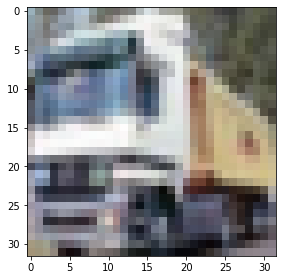

In [5]:
imshow(train_images[1])

In [6]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

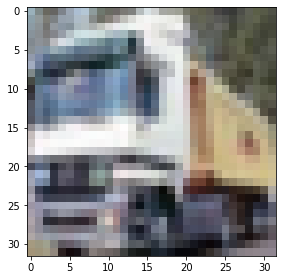

In [7]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[1]))

In [8]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((4, 4, 256)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
]
)

In [10]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32,32, 3)),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Flatten(),
   Dense(1)]
)

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [12]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [15]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

0 [4.345895   0.10827622] 138.46193861961365


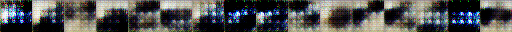

1 [3.910839   0.17352307] 136.0283420085907


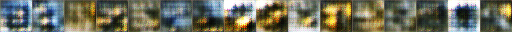

2 [3.2624948  0.27004284] 136.1270031929016


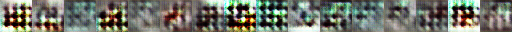

3 [3.024158  0.3685127] 136.1228804588318


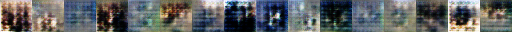

4 [2.9119656 0.3689593] 145.06684947013855


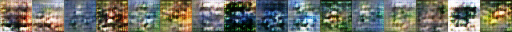

5 [2.902426  0.3830723] 144.5042827129364


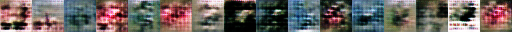

6 [2.8934479 0.367367 ] 144.2321171760559


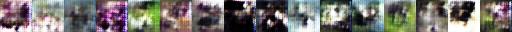

7 [3.2333353  0.30769488] 145.69530534744263


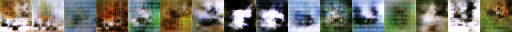

8 [3.1006138 0.3383826] 142.11074876785278


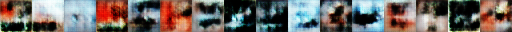

9 [3.4455764  0.27022532] 141.50758481025696


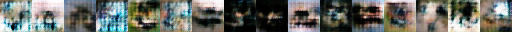

10 [3.7361884  0.22217162] 138.97373843193054


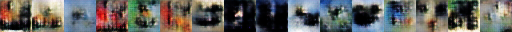

11 [3.826521   0.23242271] 136.8815839290619


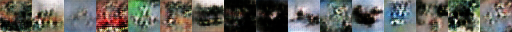

12 [3.7548306  0.25964537] 137.26475167274475


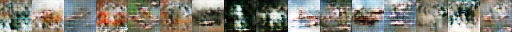

13 [3.4136455  0.28464007] 137.22128987312317


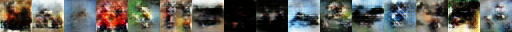

14 [3.4709818  0.29016688] 137.06947350502014


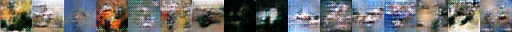

15 [3.26655 0.32505] 137.0942394733429


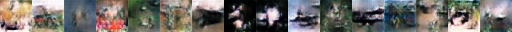

16 [3.2743738 0.3133299] 137.00904321670532


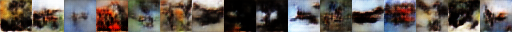

17 [3.2400098  0.32485148] 136.98783564567566


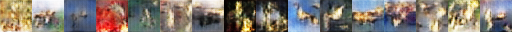

18 [3.1321793  0.34577736] 136.92912602424622


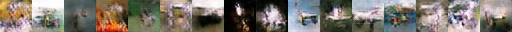

19 [2.9625711  0.40294337] 137.02227568626404


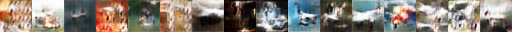

20 [2.9995944  0.41483065] 137.04063653945923


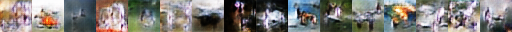

21 [2.7649055  0.42535484] 137.10880064964294


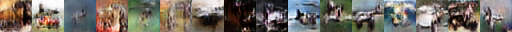

22 [2.7000554 0.4231613] 137.37370824813843


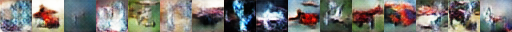

23 [2.5916157  0.46439973] 136.75379610061646


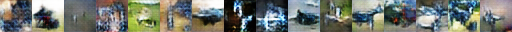

24 [2.5379014 0.4698046] 136.83779168128967


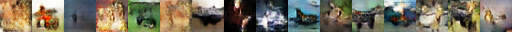

25 [2.5214815  0.47469333] 136.7428755760193


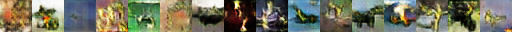

26 [2.4750211  0.49784854] 137.1069405078888


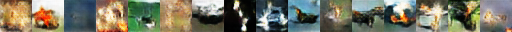

27 [2.386978   0.51857924] 137.09150195121765


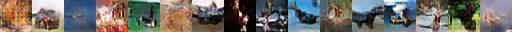

28 [2.332417  0.5163293] 137.32990503311157


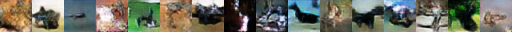

29 [2.3430037 0.5139802] 137.05030965805054


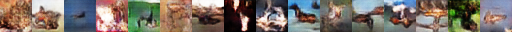

In [16]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  